In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os

In [2]:
#Mounting on co-lab


from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/XD2Net_CaseStudy') # change folder name




Mounted at /content/drive


In [3]:
my_dir = "/content/drive/My Drive/XD2Net_CaseStudy"
log_file = my_dir+"/MIMICEL ANALYSIS/filtered_mimicel.csv" #the correct and most recent version

df = pd.read_csv(log_file)
df.head()

,stay_id,subject_id,hadm_id,timestamps,activity,gender,race,arrival_transport,disposition,seq_num,...,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn,los
0,30000012,11714491,21562392.0,2126-02-14 20:22:00,Enter the ED,F,WHITE,AMBULANCE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,11714491,21562392.0,2126-02-14 20:22:01,Triage in the ED,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,spironolactone,6818.0,1.672902e+10,2.0,6043.0,Aldosterone Receptor Antagonists,NaN,NaN,NaN
3,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,spironolactone,6818.0,1.672902e+10,1.0,5658.0,"Diuretic - Aldosterone Receptor Antagonist, No...",NaN,NaN,NaN
4,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,rifaximin,66295.0,5.486862e+10,1.0,5844.0,Rifamycins and Related Derivative Antibiotics,NaN,NaN,NaN


In [4]:
df['timestamps'] = pd.to_datetime(df['timestamps'])
df['hour'] = df['timestamps'].dt.round("H")


#### Extraction of Static Features

Static Features can be extracted at the point of "Enter the ED" activity

In [5]:
df_static = df.loc[df['activity'] == 'Enter the ED'][['stay_id','gender','race','arrival_transport']]
df_static.head()

,stay_id,gender,race,arrival_transport
0,30000012,F,WHITE,AMBULANCE
22,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN
36,30000038,F,WHITE,AMBULANCE
54,30000039,M,WHITE,WALK IN
71,30000055,F,OTHER,WALK IN


In [6]:
df_static_2 = df.loc[df['activity'] == 'Triage in the ED'][['stay_id','pain','acuity','chiefcomplaint']]
df_static_2.head()

,stay_id,pain,acuity,chiefcomplaint
1,30000012,0,2.0,CHANGE IN MENTAL STATUS
23,30000017,0,3.0,"ETOH, Unable to ambulate"
37,30000038,0,3.0,Cough
55,30000039,0,3.0,s/p Fall
72,30000055,0,3.0,L Ear pain


In [7]:
df_static = df_static.merge(df_static_2, on = 'stay_id')
df_static.head()

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint
0,30000012,F,WHITE,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0,3.0,"ETOH, Unable to ambulate"
2,30000038,F,WHITE,AMBULANCE,0,3.0,Cough
3,30000039,M,WHITE,WALK IN,0,3.0,s/p Fall
4,30000055,F,OTHER,WALK IN,0,3.0,L Ear pain


### Extraction of information from the chief complaint - using topic modelling

In [ ]:
# Load the regular expression library
import re
df_static['chiefcomplaint'] = df_static['chiefcomplaint'].astype(str)
# Remove punctuation
df_static['chiefcomplaint_processed'] = df_static['chiefcomplaint'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_static['chiefcomplaint_processed'] = df_static['chiefcomplaint_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df_static['chiefcomplaint_processed'].head()

0    change in mental status
1    etoh unable to ambulate
2                      cough
3                   s/p fall
4                 l ear pain
Name: chiefcomplaint_processed, dtype: object

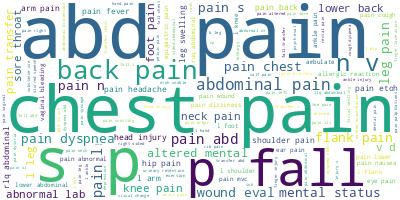

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_static['chiefcomplaint_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['/'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
df_static['chiefcomplaint_processed'] = df_static['chiefcomplaint_processed'].replace('abd','abdominal')
data = df_static['chiefcomplaint_processed'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['change', 'mental', 'status']


#### Manual topic modelling using medical context

Approach
* tokenize the chief complaint column into individual words
* Identify the top 100 keywords present in the chief complaint
* Segregate the keywords into different chief complain categories (supported by literature)
* Calculate the number of keywords in each category present in the each tokenized chief complaint. let `n` be the number of matching keywords in a given chief complaint, for a given chief complaint category.
* Then, `average(n/# of tokens in the chief complaint + n/# of keywords in the chief complaint category)` is calculated as the likelihood of that chief complaint belonging to that chief complaint category

In [ ]:
words = []
for sent in data_words:
  words.extend(sent)

from collections import Counter

word_counts = Counter(words)
# Get the 100 most common terms
most_common_terms = word_counts.most_common(100)

key_words = [term for term, count in most_common_terms]


In [ ]:
#Keyword based dictionaries

#highlevel category
cc_cat = {'General and Unspecified':['allergic','headache','fever','fall', 'headache', 'weakness', 'dizziness', 'swelling', 'cough', 'wound', 'throat', 'sore', 'bleeding','hypotension', 'lightheaded', 'abscess'],
'Blood and Immune':['anemia', 'tachycardia','dehydration'],
'Endocrine':['hyperglycemia','hypotension', 'presyncope','dehydration'],
'Respiratory':['dyspnea', 'dizziness', 'cough', 'throat'],
'Digestive':['pain','abd', 'abdominal','nausea', 'vomiting', 'constipation', 'rectal', 'diarrhea', 'brbpr','rlq', 'epigastric', 'ruq','llq','distention'],
'Urologic':['dysuria','urinary','hematuria','distention'],
'Eye/Ear/Skin':['eye', 'bleeding', 'rash','ear','pain'],
'Preganancy related':['bleeding',  'pregnant','hypertension'],
'Cardiovascular':['chest','pain', 'dizziness', 'palpitations', 'hypertension','dyspnea','syncope','hypotension', 'epigastric', 'presyncope', 'tachycardia', 'lightheaded'],
'Genital':['vaginal'],
'Musculoskeletal':['pain','lower','knee', 'laceration','foot','wound','shoulder','hip','hand','ankle','leg','injury','head', 'back', 'swelling','arm', 'sore','finger', 'bleeding', 'ambulate', 'wrist', 'fracture','toe'],
'Neurological':['head','dyspnea','syncope', 'numbness','seizure','hypotension'],
'Psychological':['depression','altered','mental','anxiety','confusion','dyspnea', 'dizziness', 'presyncope', 'tachycardia', 'lightheaded', 'psych','status']}


#special flags
cc_flag = {'Motor vehicle Collision':['mvc'],
'Suicide Ideation/ Self Injury':['si'],
'Assault':['assault'],
'Shortness of breath':['sob'],
'Substance presence':['etoh', 'substance'],
'Transfer':['transfer'],
'Status Post':['s/p']}

In [ ]:
cc_cat_labels = ['General and Unspecified','Blood and Immune','Endocrine','Respiratory','Digestive','Urologic'
                ,'Eye/Ear/Skin','Preganancy related' ,'Cardiovascular','Genital','Musculoskeletal','Neurological','Psychological']

cc_flag_labels = ['Motor vehicle Collision','Suicide Ideation/ Self Injury','Assault','Shortness of breath','Substance presence','Transfer','Status Post']
chiefcomplaint_category = []
chiefcomplaint_flag = []

for i,word in enumerate(data_words):
  set_comp = set(word)

  cat_prob = 0.00000005
  final_category = 'Other'

  for cat in cc_cat_labels:
    set_comp_cat = set(cc_cat[cat])
    n = intersection_size = len(set_comp & set_comp_cat)
    cat_prob_temp = (n/(len(set_comp)+1))


    if cat_prob < cat_prob_temp:
      cat_prob = cat_prob_temp
      final_category = cat

  final_flag = []

  for flag in cc_flag_labels:
    set_comp_flag = set(cc_flag[flag])
    if len(set_comp & set_comp_flag)>0:
      final_flag.append(flag)

  final_flag_str = ','.join(final_flag)


  chiefcomplaint_category.append(final_category)
  chiefcomplaint_flag.append(final_flag_str)




In [ ]:
df_t = pd.DataFrame({'chiefcomplaint':df_static['chiefcomplaint'],
                    'chiefcomplaint_category':chiefcomplaint_category,'chiefcomplaint_flag':chiefcomplaint_flag})
df_t.head(20)

,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag
0,CHANGE IN MENTAL STATUS,Psychological,
1,"ETOH, Unable to ambulate",Musculoskeletal,Substance presence
2,Cough,General and Unspecified,
3,s/p Fall,General and Unspecified,
4,L Ear pain,Eye/Ear/Skin,
5,N,Other,
6,Abnormal labs,Other,
7,"Abd pain, Vomiting",Digestive,
8,ALLERGIC REACTION,General and Unspecified,
9,S/P ASSAULT,Other,Assault


#### LDA topic modelling

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:5][:5][:30])

[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)], [(6, 1)], [(7, 1)], [(8, 1), (9, 1)]]


Optimal Number of Topic Models
So that there is minimum topic overlap and maximum topic coherance

In [ ]:
num_topics = list(range(16)[1:])
num_keywords = 15

import tensorflow as tf

with tf.device('/GPU:0'):

  LDA_models = {}
  LDA_topics = {}
  for i in num_topics:
      LDA_models[i] = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i)

      shown_topics = LDA_models[i].show_topics(num_topics=i,
                                             num_words=num_keywords,
                                             formatted=False)
      LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [ ]:
#function to evaluate the jaccard similarity between two topics, in terms of the keywords

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))

    return float(len(intersection))/float(len(union))

In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))

        jaccard_sims.append(sims)

    LDA_stability[num_topics[i]] = jaccard_sims

mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [ ]:

coherences = [gensim.models.CoherenceModel(topics = LDA_topics[i], texts =texts, corpus=corpus, dictionary = id2word).get_coherence()  for i in num_topics[:-1]]

In [ ]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [ ]:
ideal_topic_num

12

In [ ]:
topic_probabilities = LDA_models[ideal_topic_num][corpus]

# Extracting only the topic probabilities from the tuples
topic_probabilities = [dict(prob) for prob in topic_probabilities]

# Converting topic probabilities to dataframe
df_t= pd.DataFrame(topic_probabilities)
df_t.columns=[f"chiefcomplaint_cat_{i}" for i in range(ideal_topic_num)]

In [ ]:
df_t.head()

,chiefcomplaint_cat_0,chiefcomplaint_cat_1,chiefcomplaint_cat_2,chiefcomplaint_cat_3,chiefcomplaint_cat_4,chiefcomplaint_cat_5,chiefcomplaint_cat_6,chiefcomplaint_cat_7,chiefcomplaint_cat_8,chiefcomplaint_cat_9,chiefcomplaint_cat_10,chiefcomplaint_cat_11
0,0.020834,0.020834,0.020834,0.020834,0.520851,0.020834,0.270808,0.020834,0.020834,0.020834,0.020834,0.020834
1,0.517202,0.020834,0.020834,0.020834,0.020834,0.020834,0.020834,0.020834,0.020834,0.274462,0.020834,0.020834
2,0.041667,0.041667,0.041667,0.041667,0.541665,0.041668,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
3,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.541666,0.041667
4,0.027779,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.694441,0.027778,0.027778,0.027778,0.027778


In [ ]:
LDA_topic_list = ['/ '.join(LDA_topics[ideal_topic_num][i]) for i in range(ideal_topic_num)]
LDA_topic_list
df_Chief_complaint_category = pd.DataFrame({"Chief_complaint_category":LDA_topic_list})
print(df_Chief_complaint_category)

                             Chief_complaint_category
0   pain/ abd/ chest/ flank/ unable/ ambulate/ epi...
1   pain/ knee/ facial/ numbness/ hematuria/ abdom...
2   leg/ swelling/ pain/ arm/ palpitations/ dysuri...
3   pain/ back/ headache/ weakness/ lower/ body/ r...
4   transfer/ altered/ status/ mental/ cough/ ili/...
5   dyspnea/ throat/ sore/ seizure/ cough/ exertio...
6   fever/ abnormal/ labs/ diarrhea/ rash/ allergi...
7   pain/ abdominal/ foot/ syncope/ neck/ right/ l...
8   eval/ dizziness/ wound/ nausea/ vomiting/ hype...
9   etoh/ anxiety/ transfer/ depression/ ct/ fract...
10  fall/ injury/ laceration/ head/ hand/ finger/ ...
11  pain/ si/ mvc/ shoulder/ brbpr/ hip/ urinary/ ...


#### Merging the Chief complaint category with the static dataset

In [ ]:
#Merging the df_t to df_static

df_static = df_static.join(df_t[['chiefcomplaint_category','chiefcomplaint_flag']])
df_static.head(10)

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_processed,chiefcomplaint_category,chiefcomplaint_flag
0,30000012,F,WHITE,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,change in mental status,Psychological,
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0,3.0,"ETOH, Unable to ambulate",etoh unable to ambulate,Musculoskeletal,Substance presence
2,30000038,F,WHITE,AMBULANCE,0,3.0,Cough,cough,General and Unspecified,
3,30000039,M,WHITE,WALK IN,0,3.0,s/p Fall,s/p fall,General and Unspecified,
4,30000055,F,OTHER,WALK IN,0,3.0,L Ear pain,l ear pain,Eye/Ear/Skin,
5,30000094,F,WHITE,AMBULANCE,2,2.0,N,n,Other,
6,30000112,F,HISPANIC/LATINO - PUERTO RICAN,WALK IN,0,3.0,Abnormal labs,abnormal labs,Other,
7,30000177,M,ASIAN - SOUTH EAST ASIAN,WALK IN,9,2.0,"Abd pain, Vomiting",abd pain vomiting,Digestive,
8,30000202,M,BLACK/AFRICAN AMERICAN,WALK IN,3,2.0,ALLERGIC REACTION,allergic reaction,General and Unspecified,
9,30000204,M,WHITE,AMBULANCE,10,3.0,S/P ASSAULT,s/p assault,Other,Assault


In [ ]:
#Save the dataframe
df_static.to_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_static.csv", index = False)
#df_t.to_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_complaint_categories.csv", index = False)

### Analysis of the relationship between static featues and LOS

In [ ]:
df_static = pd.read_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_static.csv")
df_static.head()

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_processed,chiefcomplaint_category,chiefcomplaint_flag
0,30000012,F,WHITE,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,change in mental status,Psychological,NaN
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0,3.0,"ETOH, Unable to ambulate",etoh unable to ambulate,Musculoskeletal,Substance presence
2,30000038,F,WHITE,AMBULANCE,0,3.0,Cough,cough,General and Unspecified,NaN
3,30000039,M,WHITE,WALK IN,0,3.0,s/p Fall,s/p fall,General and Unspecified,NaN
4,30000055,F,OTHER,WALK IN,0,3.0,L Ear pain,l ear pain,Eye/Ear/Skin,NaN


In [ ]:
df_static.columns

Index(['stay_id', 'gender', 'race', 'arrival_transport', 'pain', 'acuity',
       'chiefcomplaint', 'chiefcomplaint_processed', 'chiefcomplaint_category',
       'chiefcomplaint_flag'],
      dtype='object')

In [ ]:
df_static_encoded = df_static[['stay_id',	'acuity']]
df_cc_cat = pd.get_dummies(df_static['chiefcomplaint_category'])
df_cc_flag = pd.get_dummies(df_static['chiefcomplaint_flag'].fillna('None'))
df_gender = pd.get_dummies(df_static['gender'])
df_race = pd.get_dummies(df_static['race'])
df_arrival = pd.get_dummies(df_static['arrival_transport'])

df_static_encoded = pd.concat([df_static_encoded,df_cc_cat], axis = 1)
df_static_encoded = pd.concat([df_static_encoded,df_cc_flag], axis = 1)
df_static_encoded = pd.concat([df_static_encoded,df_gender], axis = 1)
df_static_encoded = pd.concat([df_static_encoded,df_race], axis = 1)
df_static_encoded = pd.concat([df_static_encoded,df_arrival], axis = 1)

df_static_encoded.columns

Index(['stay_id', 'acuity', 'Blood and Immune', 'Cardiovascular', 'Digestive',
       'Endocrine', 'Eye/Ear/Skin', 'General and Unspecified', 'Genital',
       'Musculoskeletal', 'Neurological', 'Other', 'Preganancy related',
       'Psychological', 'Respiratory', 'Urologic', '', 'Assault',
       'Assault,Substance presence', 'Assault,Substance presence,Transfer',
       'Assault,Transfer', 'Motor vehicle Collision',
       'Motor vehicle Collision,Assault',
       'Motor vehicle Collision,Substance presence',
       'Motor vehicle Collision,Substance presence,Transfer',
       'Motor vehicle Collision,Suicide Ideation/ Self Injury',
       'Motor vehicle Collision,Suicide Ideation/ Self Injury,Transfer',
       'Motor vehicle Collision,Transfer', 'Shortness of breath',
       'Shortness of breath,Substance presence',
       'Shortness of breath,Transfer', 'Substance presence',
       'Substance presence,Transfer', 'Suicide Ideation/ Self Injury',
       'Suicide Ideation/ Self Injury

In [ ]:
df['activity'].unique()

array(['Enter the ED', 'Triage in the ED', 'Medicine reconciliation',
       'Vital sign check', 'Medicine dispensations',
       'Discharge from the ED'], dtype=object)

In [ ]:
df_los = df.loc[ df['activity']== 'Discharge from the ED'][['stay_id','los']]
df_los = df_los.merge(df_static_encoded, on = 'stay_id' )
df_los.head()

,stay_id,los,acuity,Blood and Immune,Cardiovascular,Digestive,Endocrine,Eye/Ear/Skin,General and Unspecified,Genital,...,WHITE,WHITE - BRAZILIAN,WHITE - EASTERN EUROPEAN,WHITE - OTHER EUROPEAN,WHITE - RUSSIAN,AMBULANCE,HELICOPTER,OTHER,UNKNOWN,WALK IN
0,30000012,337.0,2.0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,30000012,337.0,2.0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,30000017,242.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,30000017,242.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,30000017,242.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<ipython-input-21-91b944fb8dde>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor, dtype=np.bool))


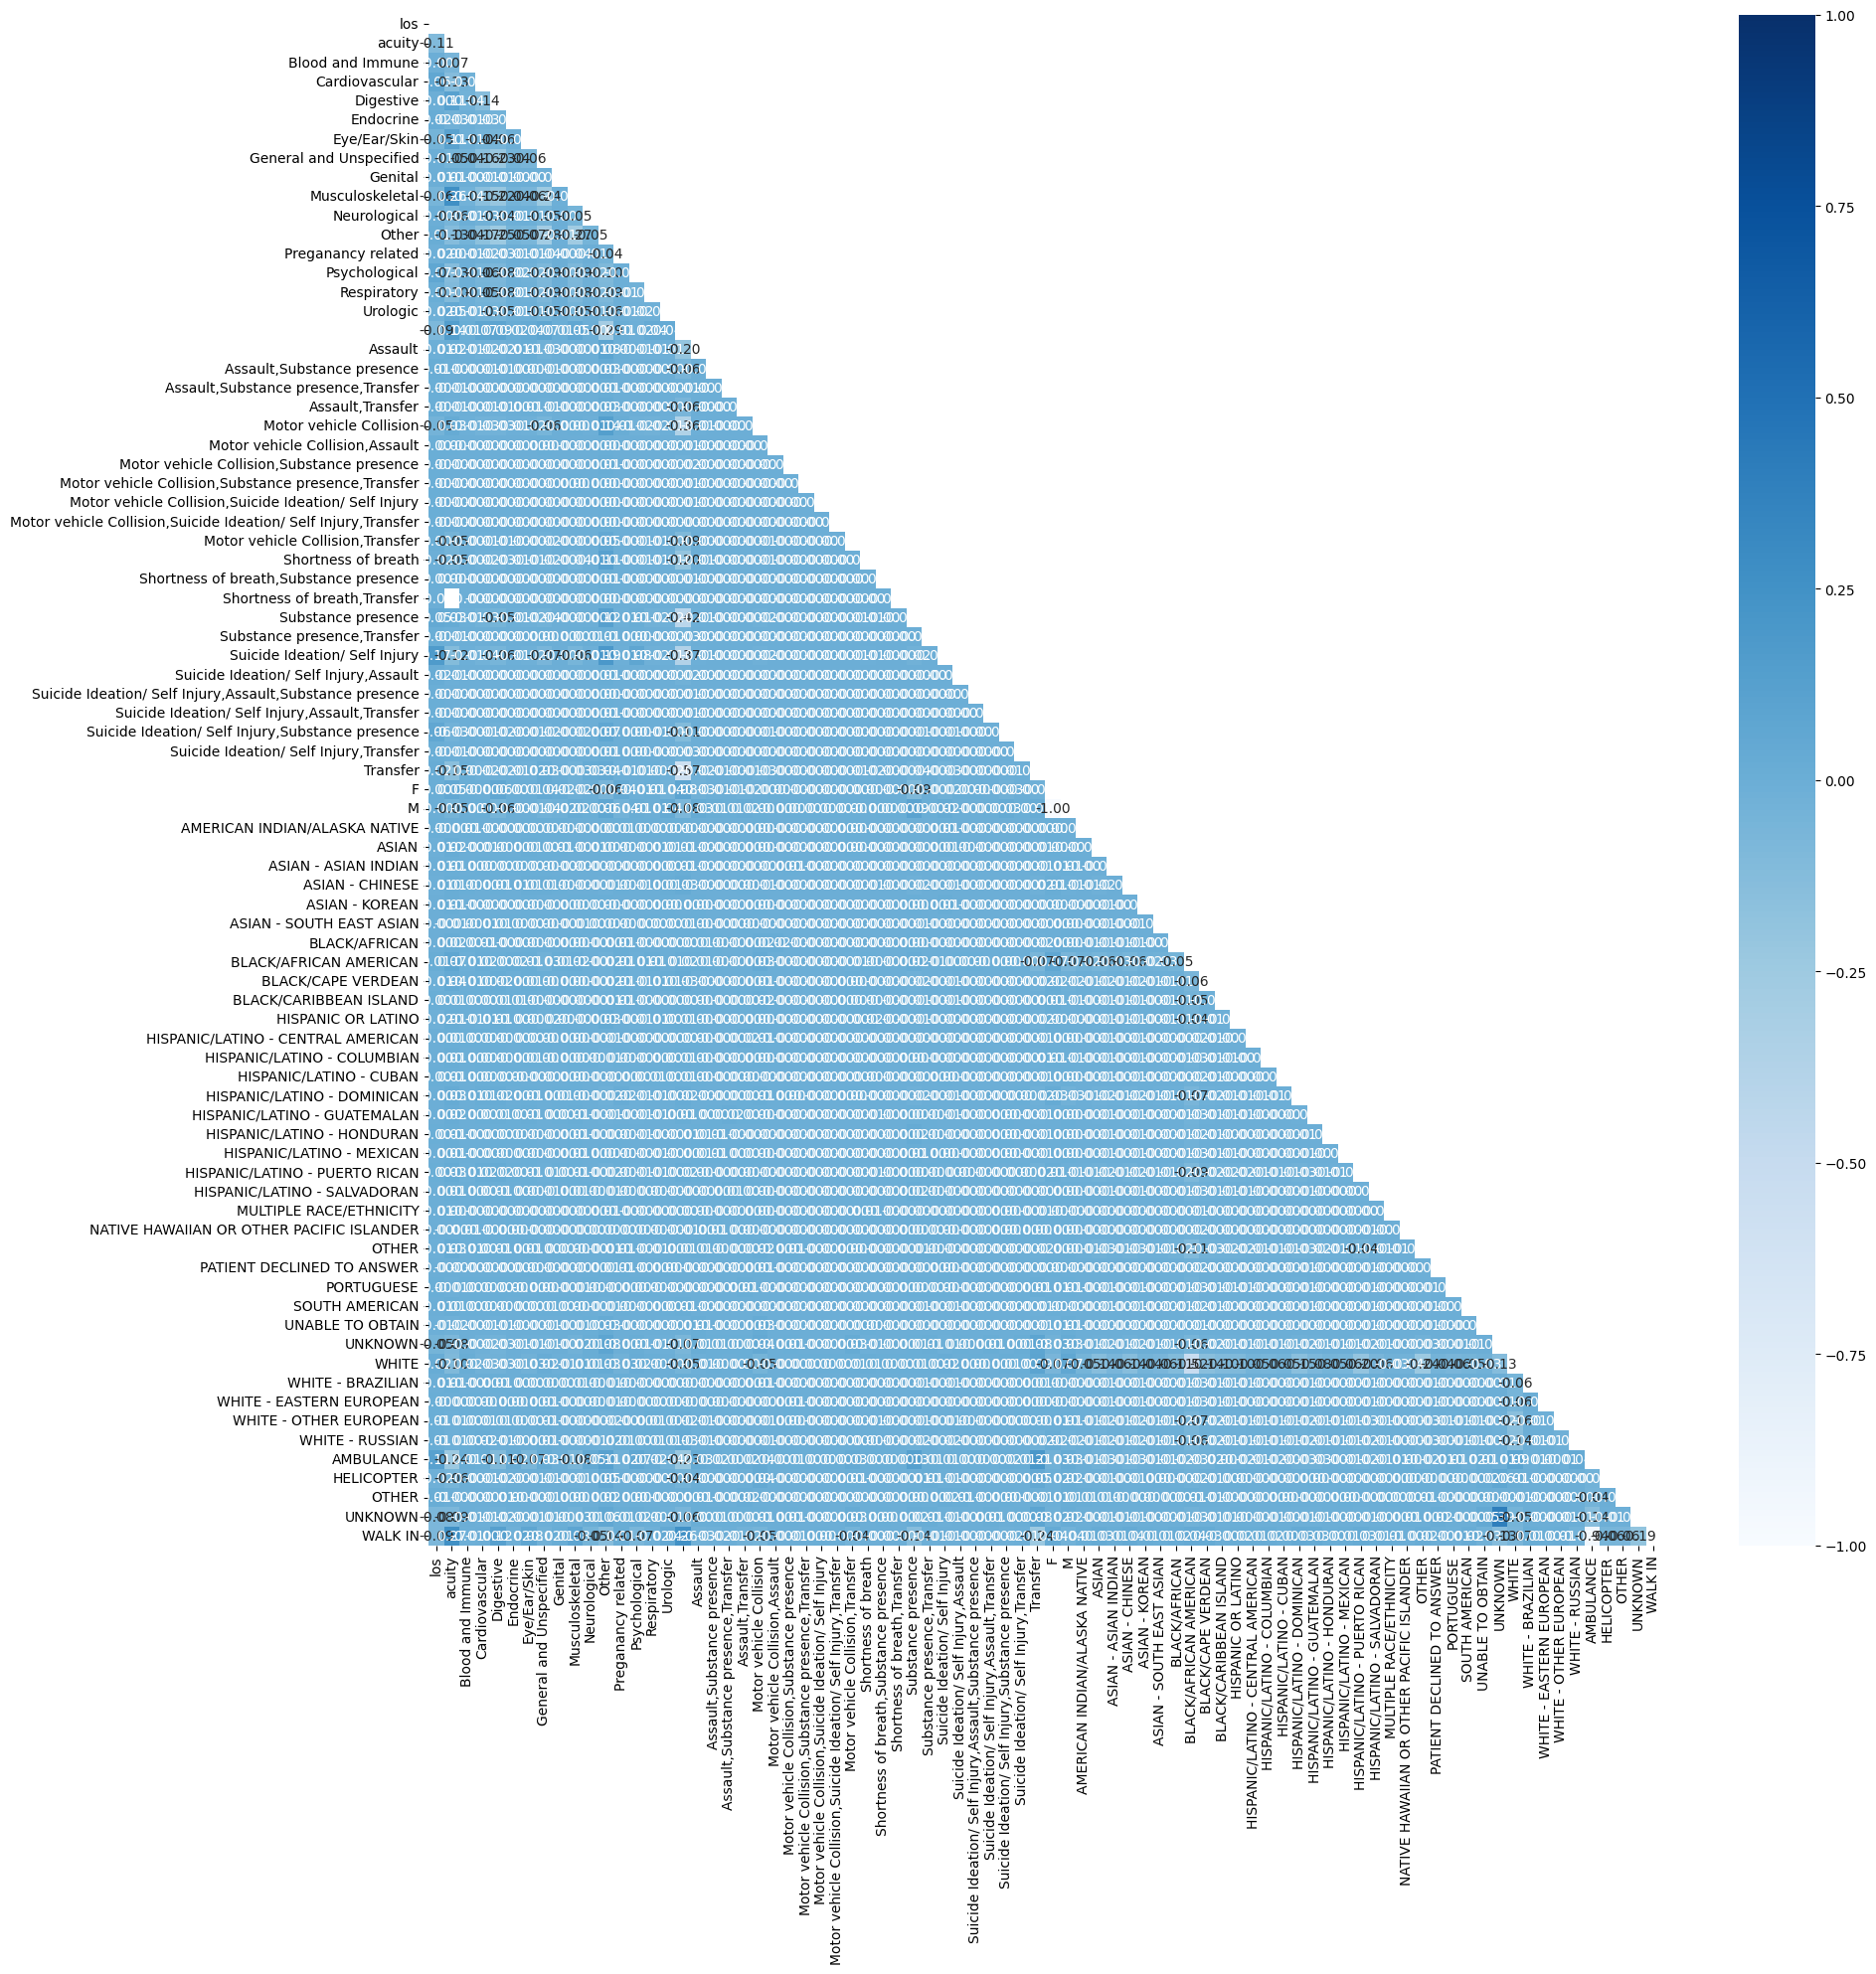

In [ ]:
cor = df_los.iloc[:,1:].corr()
mask = np.triu(np.ones_like(cor, dtype=np.bool))
plt.figure(figsize=(20,20))
ax = sn.heatmap(cor, cmap='Blues', mask = mask, annot=True, fmt='.2f',vmin=-1, vmax=1)

In [ ]:
col_list = cor.columns.to_list()
col_list = [i.replace(' ', '') for i in col_list]
col_list



In [ ]:
cor.columns = col_list
cor_features = list(cor.iloc[0].round(2))
for i,cor in enumerate(cor_features):
  if abs(cor) > 0.049:
    print(col_list[i]+': '+str(cor))

los: 1.0
acuity: -0.11
Cardiovascular: 0.06
Eye/Ear/Skin: -0.05
Musculoskeletal: -0.06
Psychological: 0.07
: -0.09
MotorvehicleCollision: -0.05
Substancepresence: 0.05
SuicideIdeation/SelfInjury: 0.17
SuicideIdeation/SelfInjury,Substancepresence: 0.06
UNKNOWN: -0.05
AMBULANCE: 0.11
UNKNOWN: -0.08
WALKIN: -0.09


### Extraction of Contextual Dynamic Features

##### number of patients treated at the event

The number of patients treated at the event is calculated by the number of patients who have arrived at ED before the event time stamp - number of patients discharged from the ED before the event time stamp

In [ ]:
df['timestamps'] = pd.to_datetime(df['timestamps'])

df_entry = df.loc[df['activity'] == 'Enter the ED'][['stay_id','timestamps']]
df_entry.columns = ['stay_id','enter_time']

df_discharge = df.loc[df['activity'] == 'Discharge from the ED'][['stay_id','timestamps']].drop_duplicates()
df_discharge.columns = ['stay_id','discharge_time']

df_ed = df_entry.merge(df_discharge, on = 'stay_id')
df_ed.head()

,stay_id,enter_time,discharge_time
0,30000012,2126-02-14 20:22:00,2126-02-15 01:59:00
1,30000017,2185-06-18 11:51:00,2185-06-18 15:53:00
2,30000038,2152-12-07 16:37:00,2152-12-07 19:55:00
3,30000039,2165-10-06 11:47:00,2165-10-06 20:18:00
4,30000055,2155-07-18 17:03:00,2155-07-18 21:12:00


In [ ]:
df_events = df[['stay_id','activity','timestamps']]
df_events['hour'] = df_events['timestamps'].dt.floor('H')
df_events['minute'] = df_events['timestamps'].dt.floor('1min')
df_events.head()

<ipython-input-85-cd41d920d47c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['hour'] = df_events['timestamps'].dt.floor('H')
<ipython-input-85-cd41d920d47c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['minute'] = df_events['timestamps'].dt.floor('1min')


,stay_id,activity,timestamps,hour,minute
0,30000012,Enter the ED,2126-02-14 20:22:00,2126-02-14 20:00:00,2126-02-14 20:22:00
1,30000012,Triage in the ED,2126-02-14 20:22:01,2126-02-14 20:00:00,2126-02-14 20:22:00
2,30000012,Medicine reconciliation,2126-02-14 22:21:00,2126-02-14 22:00:00,2126-02-14 22:21:00
3,30000012,Medicine reconciliation,2126-02-14 22:21:00,2126-02-14 22:00:00,2126-02-14 22:21:00
4,30000012,Medicine reconciliation,2126-02-14 22:21:00,2126-02-14 22:00:00,2126-02-14 22:21:00


In [ ]:
df_hour = df_events[['hour']].drop_duplicates()
df_minute = df_events[['minute']].drop_duplicates()

print(len(df_events))
print(len(df_hour))
print(len(df_minute))

7488243
734028
3408809


In [ ]:
#computation of crowdedness
df_hour['patient_count'] = df_hour.apply(lambda row: len(df_ed[(df_ed['enter_time'] <= row['hour']) & (df_ed['discharge_time'] > row['hour'])]), axis=1)
df_hour.head()


,hour,patient_count
0,2126-02-14 20:00:00,6
2,2126-02-14 22:00:00,6
11,2126-02-14 23:00:00,7
12,2126-02-15 00:00:00,7
19,2126-02-15 01:00:00,4


In [ ]:
df_events = df_events.merge(df_hour, on = 'hour')[['stay_id', 'activity', 'timestamps', 'hour', 'patient_count']].drop_duplicates()
df_events.to_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_event_level_patient_count.csv", index = False)

##### event transition

Transition of events and event durations

In [ ]:
df_act = df[['stay_id','timestamps','activity']]
df_act['activity_index'] = df_act.groupby('stay_id')['timestamps'].rank(ascending=True, method = 'first')
df_act.head(20)

<ipython-input-86-a17a6a739540>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_act['activity_index'] = df_act.groupby('stay_id')['timestamps'].rank(ascending=True, method = 'first')


,stay_id,timestamps,activity,activity_index
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,9.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,10.0


In [ ]:
df_act['activity_index_next'] = df_act['activity_index']-1
df_loops = df_act.merge(df_act, left_on = ['stay_id','activity_index'],right_on =  ['stay_id','activity_index_next'], how = 'left')
df_loops.head()


<ipython-input-87-74ba02aa7c63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_act['activity_index_next'] = df_act['activity_index']-1


,stay_id,timestamps_x,activity_x,activity_index_x,activity_index_next_x,timestamps_y,activity_y,activity_index_y,activity_index_next_y
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0,0.0,2126-02-14 20:22:01,Triage in the ED,2.0,1.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0,1.0,2126-02-14 22:21:00,Medicine reconciliation,3.0,2.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,2.0,2126-02-14 22:21:00,Medicine reconciliation,4.0,3.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,3.0,2126-02-14 22:21:00,Medicine reconciliation,5.0,4.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,4.0,2126-02-14 22:21:00,Medicine reconciliation,6.0,5.0


In [ ]:
df_loops = df_loops[['stay_id', 'timestamps_x', 'activity_x', 'activity_index_x',
       'timestamps_y', 'activity_y']]
df_loops.columns =  ['stay_id', 'timestamps', 'activity', 'activity_index','timestamps_next', 'activity_next'
       ]

In [ ]:
df_loops['loop_len_min'] = round(( df_loops['timestamps_next'] -df_loops['timestamps']).dt.total_seconds() / 60,0)
df_loops.head()

,stay_id,timestamps,activity,activity_index,timestamps_next,activity_next,loop_len_min
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0,2126-02-14 20:22:01,Triage in the ED,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0,2126-02-14 22:21:00,Medicine reconciliation,119.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,2126-02-14 22:21:00,Medicine reconciliation,0.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,2126-02-14 22:21:00,Medicine reconciliation,0.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,2126-02-14 22:21:00,Medicine reconciliation,0.0


##### Outcomes

In [ ]:
df_entry = df.loc[df['activity'] == 'Enter the ED'][['stay_id','timestamps']]
df_entry.columns = ['stay_id','enter_time']

df_discharge = df.loc[df['activity'] == 'Discharge from the ED'][['stay_id','timestamps','disposition']].drop_duplicates()
df_discharge.columns = ['stay_id','discharge_time','disposition']

##### Vital sign readings

In [ ]:
df_vitals = df[['stay_id','timestamps','activity','temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp']].drop_duplicates()

df_vitals.ffill(inplace=True)

#resetting the enter the ED vitals values to NaN
cols = ['temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp']
for col in cols:
  df_vitals.loc[df_vitals['activity'] == 'Enter the ED',col] = np.nan

df_vitals.head(20)

,stay_id,timestamps,activity,temperature,heartrate,resprate,o2sat,sbp,dbp
0,30000012,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,98.8,96.0,18.0,93.0,160.0,54.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0
11,30000012,2126-02-14 23:43:00,Vital sign check,98.8,80.0,13.0,99.0,112.0,44.0
12,30000012,2126-02-15 00:16:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0
13,30000012,2126-02-15 00:17:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0
16,30000012,2126-02-15 00:44:00,Medicine dispensations,98.8,80.0,13.0,99.0,112.0,44.0
18,30000012,2126-02-15 00:50:00,Vital sign check,98.6,88.0,16.0,100.0,135.0,51.0
19,30000012,2126-02-15 01:22:00,Medicine dispensations,98.6,88.0,16.0,100.0,135.0,51.0


###### Vital sign reading differences:

Context iinformation for vital sign readings
At the triage stage, we evaluate how different is the patient's vital signs compared to the established median for a healthy individual. We extract this context information from the domain relevant sources.



*   https://www.physio-pedia.com/Vital_Signs
*   https://meded.ucsd.edu/clinicalmed/vital.html



In [ ]:
#difference of vital signs compared to the previous readings
row_diffs = df_vitals[['temperature', 'heartrate', 'resprate','o2sat', 'sbp', 'dbp']].diff()
row_diffs.columns =  ['temperature_diff', 'heartrate_diff', 'resprate_diff','o2sat_diff', 'sbp_diff', 'dbp_diff']
df_vitals = df_vitals.join(row_diffs)
df_vitals.head(20)

,stay_id,timestamps,activity,temperature,heartrate,resprate,o2sat,sbp,dbp,temperature_diff,heartrate_diff,resprate_diff,o2sat_diff,sbp_diff,dbp_diff
0,30000012,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,98.8,96.0,18.0,93.0,160.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0
11,30000012,2126-02-14 23:43:00,Vital sign check,98.8,80.0,13.0,99.0,112.0,44.0,0.0,-16.0,-5.0,6.0,-48.0,-10.0
12,30000012,2126-02-15 00:16:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0
13,30000012,2126-02-15 00:17:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0
16,30000012,2126-02-15 00:44:00,Medicine dispensations,98.8,80.0,13.0,99.0,112.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0
18,30000012,2126-02-15 00:50:00,Vital sign check,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,8.0,3.0,1.0,23.0,7.0
19,30000012,2126-02-15 01:22:00,Medicine dispensations,98.6,88.0,16.0,100.0,135.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#difference of vital signs compared to reference ranges
ref_diffs = df_vitals[['temperature', 'heartrate', 'resprate','o2sat', 'sbp', 'dbp']] - [98.6, 75, 15, 96,120,80]
ref_diffs.columns = ['temperature_ref_diff', 'heartrate_ref_diff', 'resprate_ref_diff','o2sat_ref_diff', 'sbp_ref_diff', 'dbp_ref_diff']
df_vitals = df_vitals.join(ref_diffs)

In [ ]:

df_vitals.head(10)

,stay_id,timestamps,activity,temperature,heartrate,resprate,o2sat,sbp,dbp,temperature_diff,...,resprate_diff,o2sat_diff,sbp_diff,dbp_diff,temperature_ref_diff,heartrate_ref_diff,resprate_ref_diff,o2sat_ref_diff,sbp_ref_diff,dbp_ref_diff
0,30000012,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,98.8,96.0,18.0,93.0,160.0,54.0,NaN,...,NaN,NaN,NaN,NaN,0.2,21.0,3.0,-3.0,40.0,-26.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
11,30000012,2126-02-14 23:43:00,Vital sign check,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
12,30000012,2126-02-15 00:16:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,0.0,0.0,0.0,0.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
13,30000012,2126-02-15 00:17:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,0.0,0.0,0.0,0.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
16,30000012,2126-02-15 00:44:00,Medicine dispensations,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,0.0,0.0,0.0,0.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
18,30000012,2126-02-15 00:50:00,Vital sign check,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,...,3.0,1.0,23.0,7.0,0.0,13.0,1.0,4.0,15.0,-29.0
19,30000012,2126-02-15 01:22:00,Medicine dispensations,98.6,88.0,16.0,100.0,135.0,51.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.0,1.0,4.0,15.0,-29.0


##### Medicine dispensations

In [ ]:
df_meds = df.loc[df['activity']=='Medicine dispensations'][['stay_id','activity','timestamps','name']]
df_meds = df_meds.groupby(['stay_id','activity','timestamps'])['name'].agg(', '.join).reset_index()
df_meds.head()

,stay_id,activity,timestamps,name
0,30000012,Medicine dispensations,2126-02-15 00:44:00,"Gabapentin, Spironolactone"
1,30000012,Medicine dispensations,2126-02-15 01:22:00,CefTRIAXone (Mini Bag Plus)
2,30000017,Medicine dispensations,2185-06-18 14:48:00,"Multivitamins, Multivitamins, Multivitamins, T..."
3,30000017,Medicine dispensations,2185-06-18 14:49:00,FoLIC Acid
4,30000038,Medicine dispensations,2152-12-07 18:31:00,CefTRIAXone 1gm/100mL 100mL Bag


In [ ]:
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['/'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#process the medicine name for identify which medication has been offered.

df_meds['name'] = df_meds['name'].astype(str)
# Remove punctuation
df_meds['name_processed'] = df_meds['name'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_meds['name_processed']  = df_meds['name_processed'] .map(lambda x: x.lower())

data = df_meds['name_processed'] .values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])


['gabapentin', 'spironolactone']


In [ ]:
words = []
for sent in data_words:
  words.extend(sent)

from collections import Counter

word_counts = Counter(words)
# Get the 100 most common terms
most_common_terms = word_counts.most_common(100)

key_words = [term for term, count in most_common_terms]
key_words

['ml',
 'mg',
 'tab',
 'vial',
 'ondansetron',
 'acetaminophen',
 'morphine',
 'lorazepam',
 'bag',
 'neb',
 'sodium',
 'hydromorphone',
 'sulfate',
 'oxycodone',
 'syr',
 'lidocaine',
 'dilaudid',
 'magnesium',
 'ceftriaxone',
 'tetanus',
 'ketorolac',
 'ibuprofen',
 'fentanyl',
 'diphtox',
 'aspirin',
 'immediate',
 'albuterol',
 'sulfat',
 'vancomycin',
 'cap',
 'diazepam',
 'acellular',
 'pertuss',
 'soln',
 'chloride',
 'ipratropium',
 'aluminum',
 'potassium',
 'bromide',
 'gm',
 'release',
 'metoprolol',
 'prednisone',
 'pantoprazole',
 'gabapentin',
 'ciprofloxacin',
 'jelly',
 'udcup',
 'heparin',
 'azithromycin',
 'haloperidol',
 'readi',
 'cat',
 'barium',
 'vancomyci',
 'hydrox',
 'simet',
 'succ',
 'multivitamins',
 'rel',
 'mini',
 'mcg',
 'plus',
 'citrate',
 'furosemide',
 'propofol',
 'cefepime',
 'viscous',
 'diphenhydramine',
 'tartrate',
 'urojet',
 'thiamine',
 'metronidazole',
 'flagyl',
 'odt',
 'midazolam',
 'metoclopramide',
 'amp',
 'calcium',
 'cefazolin',
 '

In [ ]:
#Keyword based dictionaries

#highlevel category
med_cat = {'Nausea and vomit prevension':['ondansetron','metoclopramide'],
'Fever reducer':['acetaminophen','aspirin'],
'Pain reliever':['morphine', 'hydromorphone', 'oxycodone', 'dilaudid', 'ibuprofen', 'fentanyl','nitroglycerin'],
'Sedative':['lorazepam','diazepam','midazolam'],
'Anti-biotic':['ceftriaxone', 'vancomycin', 'ciprofloxacin','azithromycin','vancomyci','cefepime','metronidazole','cefazolin','piperacillin',  'tazobactam', 'sulfameth','trimeth'],
'Anti-inflamatory':['ketorolac','prednisone','dexamethasone'],
'Airflow improver':['albuterol','ipratropium'],
'Cardio medication':['metoprolol','lisinopril'],
'Reflux reliever':['pantoprazole','omeprazole'],
'Nerve pain reliever':['gabapentin'],
'Blood thinner':['heparin'],
'Anti-psychotic':['haloperidol'],
'Multivitamin':['multivitamins'],
'General anesthetic':['propofol'],
'Antihistamin':['diphenhydramine'],
'Local anesthetic':['uroject'],
'IBS reliever':['donnatol']}


#special flags
med_method = {'Oral':['tab','odt','cap','syr'],
'Vial':['vial'],
'IV':['bag'],
'Nebulaize':['neb'],
'Solution':['soln']}

In [ ]:
med_cat_labels = list(med_cat.keys())

med_method_labels = list(med_method.keys())
medication_category = []
medication_method = []

for i,word in enumerate(data_words):
  set_med = set(word)

  cat_prob = 0.00000005
  final_category = 'Other'

  for cat in med_cat_labels:
    set_med_cat = set(med_cat[cat])
    n = intersection_size = len(set_med & set_med_cat)
    cat_prob_temp = (n/(len(set_med)+1))


    if cat_prob < cat_prob_temp:
      cat_prob = cat_prob_temp
      final_category = cat

  method_prob = 0.00000005
  final_method = 'Other'

  for met in med_method_labels:
    set_med_met = set(med_method[met])
    n = intersection_size = len(set_med & set_med_met)
    method_prob_temp = (n/(len(set_med)+1))


    if method_prob < method_prob_temp:
      method_prob = method_prob_temp
      final_method = met


  medication_category.append(final_category)
  medication_method.append(final_method)


In [ ]:
df_t = pd.DataFrame({'name':df_meds['name'],
                    'medication_category':medication_category,'medication_method':medication_method})
df_t.groupby('medication_category')['name'].size()

medication_category
Airflow improver                25736
Anti-biotic                     70573
Anti-inflamatory                25168
Anti-psychotic                   4442
Antihistamin                     6547
Blood thinner                    6711
Cardio medication               15013
Fever reducer                  115801
General anesthetic               4398
IBS reliever                     5742
Multivitamin                     2949
Nausea and vomit prevension     74504
Nerve pain reliever              8830
Other                          233277
Pain reliever                  163827
Reflux reliever                 11566
Sedative                        49941
Name: name, dtype: int64

In [ ]:
df_meds = df_meds.join(df_t[['medication_category','medication_method']])

In [ ]:
df_meds = df_meds[['stay_id','activity','timestamps','name','medication_category','medication_method']]
df_meds.columns = ['stay_id','activity','timestamps','medication_name','medication_category','medication_method']

In [ ]:
df_meds.head()

,stay_id,activity,timestamps,medication_name,medication_category,medication_method
0,30000012,Medicine dispensations,2126-02-15 00:44:00,"Gabapentin, Spironolactone",Nerve pain reliever,Other
1,30000012,Medicine dispensations,2126-02-15 01:22:00,CefTRIAXone (Mini Bag Plus),Anti-biotic,IV
2,30000017,Medicine dispensations,2185-06-18 14:48:00,"Multivitamins, Multivitamins, Multivitamins, T...",Multivitamin,Other
3,30000017,Medicine dispensations,2185-06-18 14:49:00,FoLIC Acid,Other,Other
4,30000038,Medicine dispensations,2152-12-07 18:31:00,CefTRIAXone 1gm/100mL 100mL Bag,Anti-biotic,IV


### Construction of Full Event Log for Prediction

In [ ]:
df.columns

Index(['stay_id', 'subject_id', 'hadm_id', 'timestamps', 'activity', 'gender',
       'race', 'arrival_transport', 'disposition', 'seq_num', 'icd_code',
       'icd_version', 'icd_title', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint', 'rhythm',
       'name', 'gsn', 'ndc', 'etc_rn', 'etccode', 'etcdescription', 'med_rn',
       'gsn_rn', 'los', 'hour'],
      dtype='object')

In [ ]:
df_mimicel_pred = df[['stay_id','timestamps', 'activity']]
df_mimicel_pred ['activity_index'] = df_mimicel_pred.groupby('stay_id')['timestamps'].rank(ascending=True, method = 'first')-1

df_loops['transition'] = df_loops['activity']+'->'+df_loops['activity_next']

df_mimicel_pred.head(10)

<ipython-input-106-ed41b5754d6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mimicel_pred ['activity_index'] = df_mimicel_pred.groupby('stay_id')['timestamps'].rank(ascending=True, method = 'first')-1


,stay_id,timestamps,activity,activity_index
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0


In [ ]:
df_mimicel_pred = df_mimicel_pred.merge(df_loops[['stay_id','transition','loop_len_min','activity_index']], on = ['stay_id','activity_index'], how = 'left')
df_mimicel_pred.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,Medicine reconciliation->Medicine reconciliation,0.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0,Medicine reconciliation->Medicine reconciliation,0.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0,Medicine reconciliation->Medicine reconciliation,0.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0,Medicine reconciliation->Medicine reconciliation,0.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0,Medicine reconciliation->Medicine reconciliation,1.0


In [ ]:
df_mimicel_pred = df_mimicel_pred.merge(df_entry, on =  'stay_id')
df_mimicel_pred = df_mimicel_pred.merge(df_discharge, on =  'stay_id')

In [ ]:
df_mimicel_pred['los_min'] = round(( df_mimicel_pred['discharge_time'] -df_mimicel_pred['enter_time']).dt.total_seconds() / 60,0)
df_mimicel_pred['time_elapsed_min'] = round(( df_mimicel_pred['timestamps'] -df_mimicel_pred['enter_time']).dt.total_seconds() / 60,0)
df_mimicel_pred.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,time_elapsed_min
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,0.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0,Medicine reconciliation->Medicine reconciliation,1.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,120.0


In [ ]:
df_vitals.head(10)

,stay_id,timestamps,activity,temperature,heartrate,resprate,o2sat,sbp,dbp,temperature_diff,...,resprate_diff,o2sat_diff,sbp_diff,dbp_diff,temperature_ref_diff,heartrate_ref_diff,resprate_ref_diff,o2sat_ref_diff,sbp_ref_diff,dbp_ref_diff
0,30000012,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,98.8,96.0,18.0,93.0,160.0,54.0,NaN,...,NaN,NaN,NaN,NaN,0.2,21.0,3.0,-3.0,40.0,-26.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
11,30000012,2126-02-14 23:43:00,Vital sign check,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
12,30000012,2126-02-15 00:16:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,0.0,0.0,0.0,0.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
13,30000012,2126-02-15 00:17:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,0.0,0.0,0.0,0.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
16,30000012,2126-02-15 00:44:00,Medicine dispensations,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,0.0,0.0,0.0,0.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
18,30000012,2126-02-15 00:50:00,Vital sign check,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,...,3.0,1.0,23.0,7.0,0.0,13.0,1.0,4.0,15.0,-29.0
19,30000012,2126-02-15 01:22:00,Medicine dispensations,98.6,88.0,16.0,100.0,135.0,51.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.0,1.0,4.0,15.0,-29.0


In [ ]:
df_mimicel_pred = df_mimicel_pred.merge(df_vitals, on = ['stay_id','activity','timestamps'])
df_mimicel_pred = df_mimicel_pred.merge(df_meds, on = ['stay_id','activity','timestamps'], how = 'left')


In [ ]:
df_mimicel_pred[['medication_category','medication_method']] = df_mimicel_pred[['medication_category','medication_method']].fillna('None')
df_mimicel_pred.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,dbp_diff,temperature_ref_diff,heartrate_ref_diff,resprate_ref_diff,o2sat_ref_diff,sbp_ref_diff,dbp_ref_diff,medication_name,medication_category,medication_method
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,NaN,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0,Medicine reconciliation->Medicine reconciliation,1.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0,NaN,None,None


In [ ]:
df_static = pd.read_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_static.csv")
df_static.head()

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_processed,chiefcomplaint_category,chiefcomplaint_flag
0,30000012,F,WHITE,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,change in mental status,Psychological,NaN
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0,3.0,"ETOH, Unable to ambulate",etoh unable to ambulate,Musculoskeletal,Substance presence
2,30000038,F,WHITE,AMBULANCE,0,3.0,Cough,cough,General and Unspecified,NaN
3,30000039,M,WHITE,WALK IN,0,3.0,s/p Fall,s/p fall,General and Unspecified,NaN
4,30000055,F,OTHER,WALK IN,0,3.0,L Ear pain,l ear pain,Eye/Ear/Skin,NaN


In [ ]:
df_static.columns

Index(['stay_id', 'gender', 'race', 'arrival_transport', 'pain', 'acuity',
       'chiefcomplaint', 'chiefcomplaint_processed', 'chiefcomplaint_category',
       'chiefcomplaint_flag'],
      dtype='object')

In [ ]:
df_temp = df_static[['stay_id',  'arrival_transport', 'pain', 'acuity',
       'chiefcomplaint',  'chiefcomplaint_category',
       'chiefcomplaint_flag']]

In [ ]:
df_mimicel_pred = df_mimicel_pred.merge(df_temp, on = ['stay_id'])
df_mimicel_pred.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,dbp_ref_diff,medication_name,medication_category,medication_method,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,NaN,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0,Medicine reconciliation->Medicine reconciliation,1.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,-26.0,NaN,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN


In [ ]:
df_patients = pd.read_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_event_level_patient_count.csv")
df_patients.head()

,stay_id,activity,timestamps,hour,patient_count
0,30000012,Enter the ED,2126-02-14 20:22:00,2126-02-14 20:00:00,6
1,30000012,Triage in the ED,2126-02-14 20:22:01,2126-02-14 20:00:00,6
2,36204753,Enter the ED,2126-02-14 20:01:00,2126-02-14 20:00:00,6
3,36204753,Triage in the ED,2126-02-14 20:01:01,2126-02-14 20:00:00,6
4,36204753,Vital sign check,2126-02-14 20:17:00,2126-02-14 20:00:00,6


In [ ]:
df_patients= df_patients.drop_duplicates()
df_patients['timestamps'] = pd.to_datetime(df_patients['timestamps'])

df_mimicel_pred = df_mimicel_pred.merge(df_patients, on = ['stay_id', 'activity', 'timestamps'])
df_mimicel_pred.head()

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,medication_category,medication_method,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag,hour,patient_count
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 20:00:00,6
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 20:00:00,6
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,None,None,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6


In [ ]:
df_mimicel_pred.isna().sum()

stay_id                          0
timestamps                       0
activity                         0
activity_index                   0
transition                  425028
loop_len_min                425028
enter_time                       0
discharge_time                   0
disposition                      0
los_min                          0
time_elapsed_min                 0
temperature                 425028
heartrate                   425028
resprate                    425028
o2sat                       425028
sbp                         425028
dbp                         425028
temperature_diff            850056
heartrate_diff              850056
resprate_diff               850056
o2sat_diff                  850056
sbp_diff                    850056
dbp_diff                    850056
temperature_ref_diff        425028
heartrate_ref_diff          425028
resprate_ref_diff           425028
o2sat_ref_diff              425028
sbp_ref_diff                425028
dbp_ref_diff        

In [ ]:
df_mimicel_pred.to_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_pred.csv", index = False)